In [1]:
import pandas as pd
import numpy as np
from typing import Tuple, List, Dict
import matplotlib.pyplot as plt
import math

from scipy.optimize import minimize

import sys
sys.path.insert(0, '../scripts/')
import utils as utl
# from decision_tree_classifier import Decision_Tree_Classifier

In [2]:
class Decision_Tree_Classifier:
    def __init__(self) -> None:
        self.res_dict = {}
    
    def fit(self, X, y, X_cat_cols):
        self.res_dict = self.des_tree_nodes(X, y, X_cat_cols)
        
    def predict(self, X):
        return X.apply(lambda x: self.predict_single(x, self.res_dict), axis=1)

    def predict_single(self, x, res_dict):
        tp = res_dict['type']
        attr = res_dict['attr']
        if tp == 'cat':
            res = res_dict['res'][x[attr]]
        else:
            val = res_dict['vals']
            i = self.recover_index(x[attr],val)
            res = res_dict['res'][str(i)]
        
        if isinstance(res,dict):
            return self.predict_single(x, res)
        else:
            return res

    def new_nodes(self, X: pd.DataFrame, y: pd.Series, attr_max_gain: str, X_cat_cols) -> Dict:
        dct_res = {}
        cols = list(X.columns)
        cols.remove(attr_max_gain)
        X_upd = X[cols]
        Xcc = X_cat_cols.copy()
        if attr_max_gain in X_cat_cols:
            Xcc.remove(attr_max_gain)
        
        dct_res['attr'] = attr_max_gain
        if attr_max_gain in X_cat_cols:
            dct_res['type'] = 'cat'
            dct_res['vals'] = np.sort(X[attr_max_gain].unique())
            childs = {}

            for u in dct_res['vals']:
                Xn = X_upd.loc[X[attr_max_gain]==u]
                yn = y.loc[X[attr_max_gain]==u]
                if len(yn)>0:
                    childs[u] = yn.iloc[0]
                    if len(yn.unique()) > 1:
                        childs[u] = self.des_tree_nodes(Xn, yn, Xcc)
            dct_res['res'] = childs
        else:
            dct_res['type'] = 'cont'
            splits = self.get_splits(X[attr_max_gain], y)
            dct_res['vals'] = splits
            childs = {}
            for i in range(len(splits) + 1):                
                Xn = self.iloc_ranges(X_upd, X[attr_max_gain], splits, i)
                yn = self.iloc_ranges(y, X[attr_max_gain], splits, i)
                if len(yn)>0:
                    childs[str(i)] = self.des_tree_nodes(Xn, yn, Xcc)
            dct_res['res'] = childs
        return dct_res
    
    def des_tree_nodes(self, X: pd.DataFrame, y: pd.Series, X_cat_cols):
        cols = list(X.columns)
        attr_max_gain = self.get_max_ig(X, y, X_cat_cols)
        cols.remove(attr_max_gain)
        if len(cols)!=0:
            out = self.new_nodes(X, y, attr_max_gain, X_cat_cols)
            return out
        y_count = {}
        for u in y.unique():
            y_count[u] = y.loc[y==u].count()
        out = max(y_count, key=y_count.get)
        return out
    
    def info_gain_cat(self, x:pd.Series, y:pd.Series) -> float:
        """Calculates the info gain of using a given categorical attribute to describe categorical data

        Parameters
        ----------
        x : pd.Series
            Categorical values of the attribute
        y : pd.Series
            Categorical target

        Returns
        -------
        float
            Information gain
        """
        ES = self.entropy(y)
        ESv = 0
        nt = len(y)
        if nt != 0:
            for u in np.sort(x.unique()):
                Sv = y.loc[x==u]
                n = len(Sv)        
                ESv += - (n/nt)*self.entropy(Sv)
        return ES - ESv

    def info_gain_con(self, x:pd.Series, y:pd.Series) -> float:
        """Calculates the info gain of using a given continuous attribute to describe categorical data

        Parameters
        ----------
        x : pd.Series
            Categorical values of the attribute
        y : pd.Series
            Categorical target

        Returns
        -------
        float
            Information gain
        """
        splits = self.get_splits(x, y)
        ES = self.entropy(y)
        ESv = 0
        nt = len(y)
        if nt != 0:
            for i in range(len(splits) + 1):
                Sv = self.iloc_ranges(y, x, splits, i)
                n = len(Sv)
                ESv += - (n/nt)*self.entropy(Sv)
        return ES - ESv

    def get_max_ig(self, X: pd.DataFrame, y: pd.Series, X_cat_cols: List) -> str:
        """Identifies the column of X with the maximum info gain related to the target y

        Parameters
        ----------
        X : pd.DataFrame
            Input data
        y : pd.Series
            Target data
        X_cat_cols : List
            List of categorical columns of X

        Returns
        -------
        str
            Name of the column with maximum information gain
        """
        dct = {}
        cols = list(X.columns)
        for attr in cols:
            if attr in X_cat_cols:
                dct[attr] = self.info_gain_cat(X[attr], y)
            else:
                dct[attr] = self.info_gain_con(X[attr], y)
        return max(dct, key=dct.get)
    
    def iloc_ranges(self, y: pd.Series, x: pd.Series, splits: List, i: int) -> pd.Series:
        """Filters the data from the series y for which the continuous data x is between the values split[i-1] and split[i]

        Parameters
        ----------
        x : pd.Series
            Continuous data to use as base for the filtering
        y : pd.Series or pd.DataFrame
            Data to be filtered
        splits : List
            Values at which the values of x can be splitted
        i : int
            Index of the split to be used


        Returns
        -------
        pd.Series
            Filtered data
        """
        if len(x) > 0:
            if i > 0 and i < len(splits):
                Sv = y.loc[(x>splits[i-1]) & (x<=splits[i])]
            elif i == 0:
                Sv = y.loc[x<=splits[0]]
            else:
                Sv = y.loc[x>splits[-1]]
            return Sv
        return pd.Series([])

    def recover_index(self, val: float, splits: List) -> int:
        """Recovers the index at which val falls whitin the range of the values specified by splits

        Parameters
        ----------
        val : pd.Series
            Value to evaluate
        splits : List
            Limits of the split ranges.

        Returns
        -------
        int
            Recovered index
        """
        for i,v in enumerate(splits):
            if i > 0:
                if val > splits[i-1] and val <= v:
                    return i
            else:
                if val <= v:
                    return i
        return len(splits)
    
    def get_splits(self, x:pd.Series, y:pd.Series) -> np.array:
        """Returns the splits of the categorical data x, using the median x for each category of y

        Parameters
        ----------
        x : pd.Series
            Input data for which the splits will be calculated
        y : pd.Series
            Target categorical data 

        Returns
        -------
        np.array
            Limits of the splits
        """
        vals = []
        for u in y.unique():
            x_np = x.loc[y==u].to_numpy()
            vals.append(np.median(x_np))
        vals_sorted = np.sort(np.unique(np.array(vals)))
        return vals_sorted
    
    def entropy(self, y: pd.Series) -> float:
        """Calculates the entropy of y

        Parameters
        ----------
        y : pd.Series
            Categorical value for which the entropy will be calculated

        Returns
        -------
        float
            Entropy
        """
        entropy = 0
        ntt = len(y)
        if ntt != 0:
            for u in y.unique():
                y_c = y.loc[y==u]
                p = len(y_c)/ntt
                if p != 0:
                    entropy += -p*math.log2(p)
        return entropy

In [3]:
class Decision_Tree_Regressor(Decision_Tree_Classifier):
    def __init__(self) -> None:
        super().__init__()

C:\Users\an2fe\AppData\Local\Temp\ipykernel_11344\1721308745.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[c] = utl.min_max_scaling(X[c])[0]


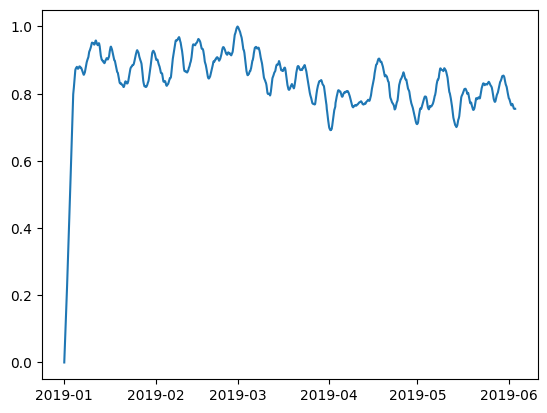

In [4]:
n = 10
roll_time = '3d'
min_n_data = 50

df_orig = pd.read_csv('../data/1.raw/electricityConsumptionAndProductioction.csv', parse_dates=['DateTime'],index_col=['DateTime'])
df = df_orig.iloc[:len(df_orig)//n]
X_cols = ['Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass']
y_col = 'Production'

df = df.rolling(roll_time).sum()

X = df[X_cols]
for c in X.columns:
    X[c] = utl.min_max_scaling(X[c])[0]

y = df[y_col]
y = utl.min_max_scaling(y)[0]

plt.plot(y)

In [5]:
def mse(y: pd.Series, y_pred: pd.Series) -> float:
    y_np = y.to_numpy()
    yp_np = y_pred.to_numpy()
    return np.mean((y_np - yp_np)**2)

In [6]:
def get_split_pred(df_s: pd.DataFrame, c: str, i: int) -> Tuple[pd.Series, float]:
    """Splits the dataframe at the given index. Returns the predicted value as the mean of the target before and after the split.

    Parameters
    ----------
    df_s : pd.DataFrame
        Input and target data sorted by column c
    c : str
        column that serves as x values
    i : int
        Index for splitting

    Returns
    -------
    Tuple[pd.Series, float]
        pd.Series: Predicted value with the means before and after the split
        float: column value at which the split was performed (average of df_s[c].iloc[i] and df_s[c].iloc[i+1])
    """
    x_split = np.mean([df_s[c].iloc[i-1:i+1]])
    yA_m = df_s['res'].loc[df_s[c] <= x_split].mean()
    yB_m = df_s['res'].loc[df_s[c] > x_split].mean()

    df_s['pred'].loc[df_s[c] <= x_split] = yA_m
    df_s['pred'].loc[df_s[c] > x_split] = yB_m    
    return df_s['pred'], x_split

def get_min_mse_column(df: pd.DataFrame, c: str) -> List:
    """Sorts the dataframe by column c, and returns the index and value of the split necessary to minimize the mean squared error

    Parameters
    ----------
    df : pd.DataFrame
        Input and target data.
    c : str
        Column for which the splits will be performed

    Returns
    -------
    List
        _description_
    """
    mse_res = []
    x_s = []
    df_s = df.sort_values(c)
    for i in range(1,len(df_s)):
        df_s['pred'], x_split = get_split_pred(df_s, c, i)
        x_s.append(x_split)
        mse_res.append(mse(df_s['res'], df_s['pred']))

    return [x_s[np.argmin(mse_res)],np.min(mse_res)]

def get_min_mse(df: pd.DataFrame) -> Tuple[str,float]:
    """Obtains the column and the split value of the column which allows to minimize the mse

    Parameters
    ----------
    df : pd.DataFrame
        Input and target dat

    Returns
    -------
    Tuple[str,float]
        str: Column that minimizes the mse
        float: Value of df[c] at which the mse is minimized
    """
    cols = [x for x in df.columns if x not in ['res','pred']]
    x_vals = []

    for c in cols:
        x_vals.append(get_min_mse_column(df, c))

    xv_np = np.array(x_vals)
    min_index = np.argmin(xv_np[:,1])
    attr = cols[min_index]
    x_v = x_vals[min_index][0]

    return attr, x_v

In [7]:
def des_tree_nodes(df: pd.DataFrame) -> Dict:
    dct_res = {}    
    attr_max_gain, x_v = get_min_mse(df)

    dct_res['type'] = 'cont'
    dct_res['attr'] = attr_max_gain
    splits = [x_v]
    dct_res['vals'] = splits

    childs = {}
    df_s = df.sort_values(attr_max_gain)
    df_low = df_s.loc[df_s[attr_max_gain] <= x_v]
    df_high = df_s.loc[df_s[attr_max_gain] > x_v]

    if len(df_low) > min_n_data:
        childs['0'] =des_tree_nodes(df_low)
    else:
        childs['0'] = df_low['res'].mean()

    if len(df_high) > min_n_data:
        childs['1'] = des_tree_nodes(df_high)
    else:
        childs['1'] = df_high['res'].mean()

    dct_res['res'] = childs
    return dct_res

In [8]:
df_split = X.copy()
df_split['res'] = y.copy()
df_split['pred'] = y.copy()
df_split = df_split.reset_index(drop = True)

res_dict = des_tree_nodes(df_split)
res_dict

{'type': 'cont',
 'attr': 'Hydroelectric',
 'vals': [0.23571986903427528],
 'res': {'0': {'type': 'cont',
   'attr': 'Nuclear',
   'vals': [0.3732842045592582],
   'res': {'0': 0.12542650622089654, '1': 0.4063506181803514}},
  '1': {'type': 'cont',
   'attr': 'Oil and Gas',
   'vals': [0.5173682607812999],
   'res': {'0': {'type': 'cont',
     'attr': 'Wind',
     'vals': [0.21541365899426462],
     'res': {'0': {'type': 'cont',
       'attr': 'Wind',
       'vals': [0.14638852317610207],
       'res': {'0': {'type': 'cont',
         'attr': 'Coal',
         'vals': [0.7288602771148972],
         'res': {'0': {'type': 'cont',
           'attr': 'Oil and Gas',
           'vals': [0.419843537020388],
           'res': {'0': {'type': 'cont',
             'attr': 'Coal',
             'vals': [0.6849714190576613],
             'res': {'0': 0.7029299501453387, '1': 0.7221411923144018}},
            '1': 0.737324781670398}},
          '1': 0.761217670747531}},
        '1': {'type': 'cont',
  

In [ ]:
def predict_single(x, res_dict):
    tp = res_dict['type']
    attr = res_dict['attr']
    if tp == 'cat':
        res = res_dict['res'][x[attr]]
    else:
        val = res_dict['vals']
        i = self.recover_index(x[attr],val)
        res = res_dict['res'][str(i)]
    
    if isinstance(res,dict):
        return predict_single(x, res)
    else:
        return res
    
def recover_index(val: float, splits: List) -> int:
    """Recovers the index at which val falls whitin the range of the values specified by splits

    Parameters
    ----------
    val : pd.Series
        Value to evaluate
    splits : List
        Limits of the split ranges.

    Returns
    -------
    int
        Recovered index
    """
    for i,v in enumerate(splits):
        if i > 0:
            if val > splits[i-1] and val <= v:
                return i
        else:
            if val <= v:
                return i
    return len(splits)    